In [3]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

Set working directory

In [4]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/SOX9/'
workingDirectory = '/home/h1bennet/brain_aging/results/03_Sox9_H3K27Ac_PipelineTest/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Read in raw peak files

In [5]:
df, mat = read_annotated_peaks('./annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
df.index.rename('PeakID', inplace=True)
# # OPTIONAL: drop bad qc samples
# tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
# df = df.loc[:, tst]
# mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

df.to_csv('./annotated_peaks/ann_raw_idr_vw_peaks_merged_filtered.txt', sep='\t')

In [6]:
df.columns.str.split('/').str[-1]

Index(['Chr', 'Start', 'End', 'Strand', 'Peak Score', 'Region Size',
       'Annotation', 'Detailed Annotation', 'Distance to TSS',
       'Nearest PromoterID', 'Entrez ID', 'Nearest Unigene', 'Nearest Refseq',
       'Nearest Ensembl', 'Gene Name', 'Gene Alias', 'Gene Description',
       'Gene Type',
       '00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_1_AL_20200610_ATTATCAA_CGACTCTC',
       '00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_2_AL_20200610_GACCAGGA_CTGGCTAT',
       '02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_20200205_AGTCAA',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA',
       '03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA'],
      dtype='object')

# Run differential peak analysis

In [7]:
# %%bash
# source activate deseq_36
# getDiffExpression.pl ./annotated_peaks/ann_raw_idr_vw_peaks_merged_filtered.txt \
# 00_sox9_10day 00_sox9_10day \
# 01_sox9_4month 01_sox9_4month 01_sox9_4month \
# -peaks > ./diff_vw_output.txt

# Create summary plots

## 10day vs. 4 months

In [8]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_vw_output.txt',
    './annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (33165, 23)
getDiffExpression selected transcripts (32446, 26)
annotatePeaks selected peaks (32446, 23)


In [9]:
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

In [10]:
comps = ['00_sox9_10day vs. 01_sox9_4month']

cols = [[0,1,2,3,4]]

groups = [[[0,1],[2,3,4]]]

colors = [['#3182bd', '#de2d26']]

00_sox9_10day vs. 01_sox9_4month
N genes downregulated 5194
N genes upregulated 5006



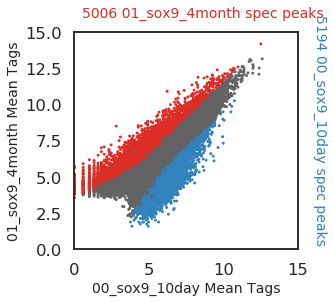

In [11]:
fc = np.log2(2)
pval = 0.05
textax = 16

for key, col, group, color in zip(comps, cols, groups, colors):
#     print(key)
#     print('mean calculated using tag dirs:')
#     for colid in peak_mat.iloc[:, col].columns.tolist():
#         print(colid)
#     print('')

    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    dot_colors = []
    dot_sizes = []
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    print(key)
    print('N genes downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)))
    print('N genes upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > fc)))
    print('')

    fig, ax = plt.subplots(figsize=(4,4))
    # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=2, #de.log10p+0.05,
        c=dot_colors)

    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags', fontsize=14)
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags', fontsize=14)
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,textax,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc > fc)), key.split(' vs. ')[1]),
        fontsize=14,
        c=color[1])
    ax.text(textax,0.5,
        s='%d %s spec peaks' % (np.sum((de.adj_pval <= pval) & (de.log2fc < -fc)), key.split(' vs. ')[0]),
        fontsize=14,
        c=color[0],
        rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter.png', bbox_inches='tight')
    # plt.close()

# Reload peak files
___
This is silly but the above script adds columns we dont want later

In [18]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_vw_output.txt',
    './annotated_peaks/ann_raw_idr_vw_peaks_merged.txt')
comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

# pull distal peaks
diff_peak_distal = diff_peak.reindex(diff_peak.index[np.abs(diff_peak['Distance to TSS']) >= 3*10**3])

annotatePeaks all peaks (33165, 23)
getDiffExpression selected transcripts (32446, 26)
annotatePeaks selected peaks (32446, 23)


In [13]:
comp_dict.keys()

dict_keys(['00_sox9_10day vs. 01_sox9_4month'])

# Extract peaks for an analysis in GREAT

In [14]:
# initialize dict and list of cell types
peak_lists = {}
cells = ['00_sox9_10day', '01_sox9_4month']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing 00_sox9_10day ...

0
For comp: 00_sox9_10day vs. 01_sox9_4month
Union set at: 5194 peaks
Intersection set at: 5194 peaks

Analyzing 01_sox9_4month ...

0
For comp: 00_sox9_10day vs. 01_sox9_4month
Union set at: 5006 peaks
Intersection set at: 5006 peaks



### Save peak and bed files for GREAT analysis

In [15]:
if not os.path.isdir('./great_analysis/'):
    os.mkdir('./great_analysis/')
    
if not os.path.isdir('./great_analysis/peak_files/'):
    os.mkdir('./great_analysis/peak_files/')
    
if not os.path.isdir('./great_analysis/bed_files/'):
    os.mkdir('./great_analysis/bed_files/')

if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [16]:
convert_dict = {'Start': int,
                'End': int}

Save each set of peaks derived from the list - in this case its just one set activated in each group

In [19]:
for key in peak_lists.keys():
    # save cell specific promoters
    tmp = diff_peak.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./great_analysis/peak_files/'+key+'_act_peaks.txt',
               sep='\t')
    tmp = diff_peak_distal.reindex(peak_lists[key]).dropna(how='all').iloc[:, :4]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./great_analysis/peak_files/'+key+'_act_peaks_distal.txt',
               sep='\t')

Save full set of peaks for background

In [21]:
diff_peak.iloc[:, :4].to_csv(
    './great_analysis/peak_files/sox9_all_peaks.txt',
    sep='\t')

Convert to bed files

In [20]:
%%bash
# delete the existing script file
rm ./peak_to_bed_great.sh
# create a script file
touch ./peak_to_bed_great.sh

In [21]:
%%bash
for peakfile in ./great_analysis/peak_files/*txt;
do bedfile=${i/act/bg};
out=${peakfile/.txt/.bed};
out=${out/peak_files/bed_files}
echo "pos2bed.pl -o $out $peakfile" >> ./peak_to_bed_great.sh
done

# Create bed files for visualization in browser

In [25]:
if not os.path.isdir('./bed_files/'):
    os.mkdir('./bed_files/')

In [26]:
!cp ./great_analysis/bed_files/*union* ./bed_files/

In [27]:
!ls ./bed_files/

00_sox9_10day_nfr_act_background.bed
00_sox9_10day_nfr_act_peaks.bed
00_sox9_10day_union_act_peaks.bed
00_sox9_10day_union_act_peaks_distal.bed
01_sox9_4month_nfr_act_background.bed
01_sox9_4month_nfr_act_peaks.bed
01_sox9_4month_union_act_peaks.bed
01_sox9_4month_union_act_peaks_distal.bed
fw_peaks_merged.bed
nfr_peaks_merged.bed
vw_peaks_merged.bed


Give track names for uploading to genome browser

In [27]:
%%bash

echo 'track name="Sox9_H3K27Ac_10day_peaks" description="Sox9 Nuclei 10day H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/00_sox9_10day_union_act_peaks.bed \
> temp && mv temp ./bed_files/00_sox9_10day_union_act_peaks.bed

echo 'track name="Sox9_H3K27Ac_4month_peaks" description="Sox9 Nuclei 4month H3K27Ac Chip-seq DESeq2 specific peaks"' \
| cat - ./bed_files/01_sox9_4month_union_act_peaks.bed \
> temp && mv temp ./bed_files/01_sox9_4month_union_act_peaks.bed

Next step... check these peaks on browser to make sure they look specific

In [28]:
# make location column for peak dict (for examining on browser)
diff_peak['location'] = diff_peak.Chr + ':' + diff_peak.Start.map(str) + '-' + diff_peak.End.map(str)

In [30]:
diff_peak.sort_values('00_sox9_10day vs. 01_sox9_4month adj. p-value', ascending=True).head(20)

,Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,...,Gene Type,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_1_AL_20200610_ATTATCAA_CGACTCTC,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/00_mouse_BL6_M_10day_SOX9_ChIP_H3K27ac_2_AL_20200610_GACCAGGA_CTGGCTAT,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/02_mouse_BL6_M_3month_SOX9_ChIP_H3K27ac_2_AL_20200205_AGTCAA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_1_AL_20200925_CATAGAGT_TGCCACCA,/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/Sox9/WT/03_mouse_MPSIIIAhet_M_4month_SOX9_ChIP_H3K27ac_2_AL_20201121_AATGCCTC_TCGATCCA,00_sox9_10day vs. 01_sox9_4month Log2 Fold Change,00_sox9_10day vs. 01_sox9_4month p-value,00_sox9_10day vs. 01_sox9_4month adj. p-value,location
PeakID,,,,,,,,,,,,,,,,,,,,,
Merged-chr3-130626604-5,chr3,130616497,130639191,+,656.940002,./peak_files/02_mouse_BL6_M_3month_SOX9_ChIP_H...,"intron (NM_027907, intron 6 of 12)","intron (NM_027907, intron 6 of 12)",10269.0,NM_027907,...,protein-coding,6.920029,6.682478,10.449449,10.381628,10.684041,4.101488,1.165124e-100,3.780363e-96,chr3:130616497-130639191
Merged-chr5-146415688-10,chr5,146397894,146432985,+,523.359985,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_145155, intron 1 of 9)","intron (NM_145155, intron 1 of 9)",30433.0,NM_145155,...,protein-coding,8.710918,8.494155,11.111513,11.206498,11.209952,2.745163,8.072505e-84,1.309602e-79,chr5:146397894-146432985
Merged-chr9-48739804-6,chr9,48726872,48751935,+,537.799988,./peak_files/02_mouse_BL6_M_3month_SOX9_ChIP_H...,"intron (NM_001033324, intron 3 of 6)","intron (NM_001033324, intron 3 of 6)",96542.0,NM_001033324,...,protein-coding,7.277151,7.553994,10.365278,10.565199,10.601886,3.358641,8.714269e-82,9.424772e-78,chr9:48726872-48751935
Merged-chr18-11900853-8,chr18,11880798,11923837,+,846.662476,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_022021, intron 3 of 8)",MER126|DNA|DNA,-61879.0,NR_035447,...,ncRNA,8.967854,9.163097,11.376814,11.462505,11.613000,2.561530,1.237799e-72,1.004041e-68,chr18:11880798-11923837
Merged-chr6-31210997-8,chr6,31197500,31222989,+,446.787506,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NR_110469, intron 1 of 3)","intron (NR_110469, intron 1 of 3)",8230.0,NR_110471,...,ncRNA,7.676813,7.886064,10.432552,10.687864,10.726477,3.062091,2.163126e-72,1.403696e-68,chr6:31197500-31222989
Merged-chr2-134970301-3,chr2,134959485,134982057,+,982.166626,./peak_files/02_mouse_BL6_M_3month_SOX9_ChIP_H...,"intron (NM_001145830, intron 2 of 31)","intron (NM_001145830, intron 2 of 31)",184607.0,NM_001145830,...,protein-coding,7.678684,7.339797,10.376654,10.261833,10.456398,3.116147,3.127490e-72,1.691243e-68,chr2:134959485-134982057
Merged-chr19-38268307-8,chr19,38258188,38283034,+,610.187500,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_020278, intron 2 of 7)",(CCCA)n|Simple_repeat|Simple_repeat,5829.0,NM_020278,...,protein-coding,8.615098,8.692038,10.921348,10.951544,11.134576,2.509304,1.383381e-66,6.412166e-63,chr19:38258188-38283034
Merged-chr7-144940560-2,chr7,144937514,144943615,+,664.699951,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,promoter-TSS (NM_007631),promoter-TSS (NM_007631),-639.0,NM_007631,...,protein-coding,9.299956,9.540293,6.000321,6.386771,5.827140,-3.806620,1.411433e-63,5.724421e-60,chr7:144937514-144943615
Merged-chr7-17059035-5,chr7,17053347,17063625,+,1009.919983,./peak_files/00_mouse_BL6_M_10day_SOX9_ChIP_H3...,"intron (NM_001162950, intron 1 of 14)","intron (NM_001162950, intron 1 of 14)",-1807.0,NM_016868,...,protein-coding,8.044079,8.467563,10.765504,11.092962,11.147359,2.926467,7.844242e-61,2.827937e-57,chr7:17053347-17063625


At this enhancer we can see that the fixed width peak does in fact miss the nucleosome free region associated with the enhancer - so theoretically would miss the motif as well.
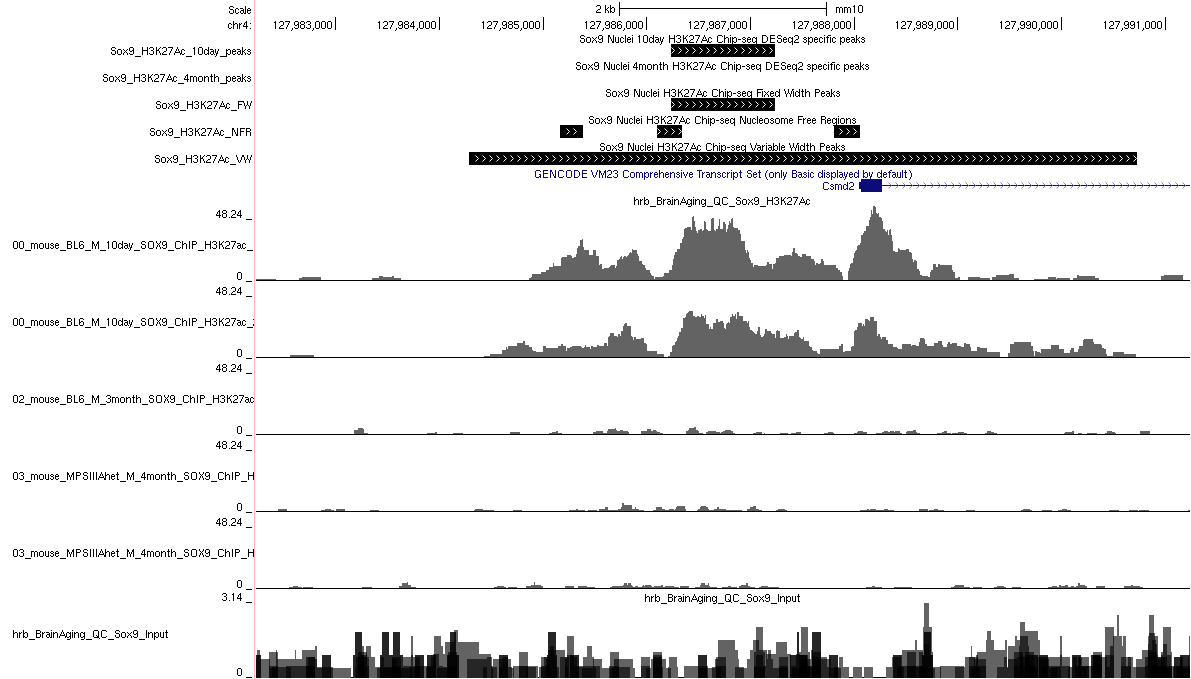
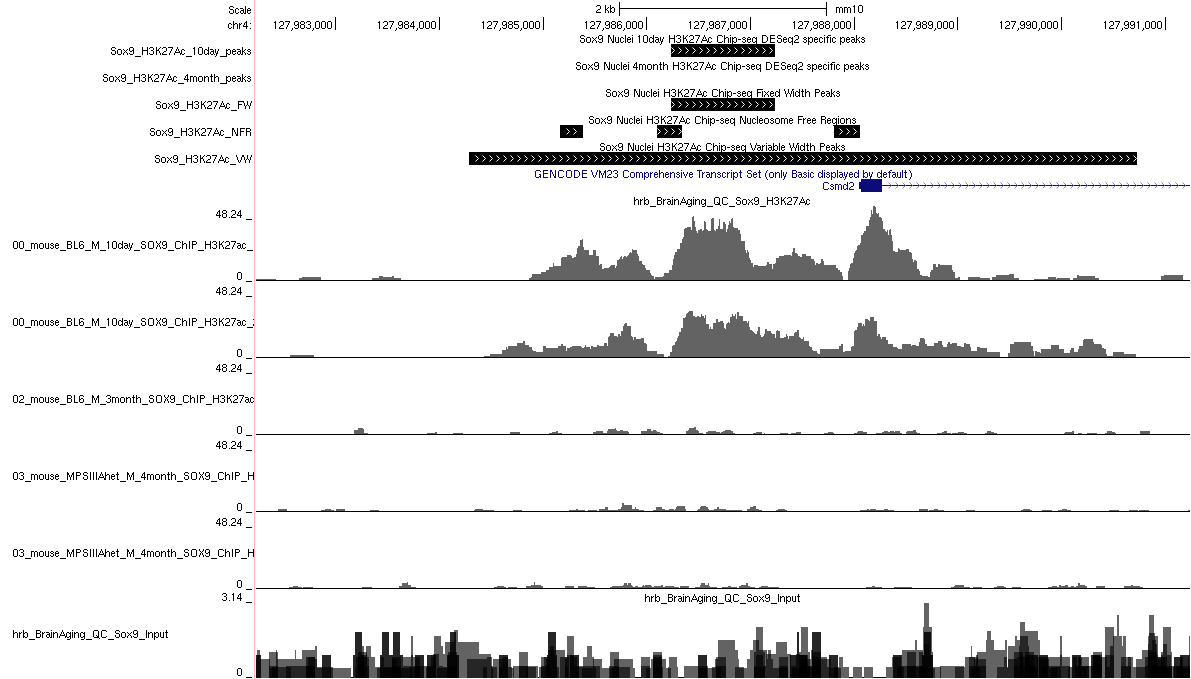